# Creating a dynamical system

Topics:
* What *is* a dynamical system in the context of **DynamicalSystems.jl**?
* How can we define a discrete or continuous system?
* What are the differences in handling large and small systems?
    * Handy Dandy definition table!
* Comment on DifferentialEquations.jl
* Docstrings

---

# Dynamical System

A "dynamical system" is a law that describes how some variables should evolve in time. This law is described by the "equations of motion" function $\vec{f}$.

There are two types of dynamical systems (in our case):

1. One is called a map, where time is a discrete quantity (like "steps" or "generations"). The equations of motion then look something like $\vec{u}_{n+1} = \vec{f}(\vec{u}_n, p, n)$ where $n$ is an integer and $p$ are the parameters of the system.

2. The other type is called an Ordinary Differential Equation (ODE), where time is a continuous quantity. Then, the equations of motion give the time derivatives of the variables: $\frac{d\vec{u}}{dt} = \vec{f}(\vec{u}, p, t)$.

In both cases $\vec{u}$ is the state of the system, a vector of the variables that define the system. For example, $\vec{u}$ may be defined as $(x, y, z)$, or as $(\theta, I)$, or as $(V, I, R, C_1, C_2)$, etc.

---


# Creating a simple discrete system


For all intents and purposes, a `DynamicalSystem` is a Julia `struct` that contains all the information of a dynamical system:
1. Equations of motion function $\vec{f}$
3. Initial state.
4. Parameter container (if the equations of motion are parameterized).
2. Jacobian of the equations of motion.


For simplicity let's focus on creating a simple discrete chaotic system, the [Hénon map](https://en.wikipedia.org/wiki/H%C3%A9non_map). 

The constructor we need is:

```julia
DiscreteDynamicalSystem(eom, state, p)
```

In order to construct a Hénon map, let's discuss the input arguments we need to pass to this constructor!

#### 1. Equations of motion
The first argument of the above constructor --`eom` -- is a **function** representing the equations of motion.

Therefore, the first step in creating a `DynamicalSystem` is to define the equations of motion. For the Hénon map they have the form:

$$
\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}
$$

Now we must make a function out of them. There is some strictness when writing this function in Julia. Specifically, it can only be one of two forms: out-of-place (oop) or in-place (iip). Here is how to define it:

* **oop** : The `eom` function **must** be in the form `eom(x, p, t) -> SVector`
  which means that given a state `x::SVector` and some parameter container
  `p` it returns a [`SVector`](http://juliaarrays.github.io/StaticArrays.jl/stable/pages/api.html#SVector-1)
  (from the [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) module)
  containing the next state.
* **iip** : The `eom` function **must** be in the form `eom!(xnew, x, p, t)`
  which means that given a state `x::Vector` and some parameter container `p`,
  it writes in-place the new state in `xnew`.

We advise to use **oop** for systems with dimension < 11, and use **iip** otherwise.

*If you are familiar with [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/), then notice that the equations of motion are defined in an identical manner*

Because the Hénon map is only 2-dimensional, we follow the advice of the documentation and take advantage of the [`StaticArrays`](https://github.com/JuliaArrays/StaticArrays.jl) module.

In [27]:
using DynamicalSystems
h_eom(x, p, t) = SVector{2}(1.0 - p[1]*x[1]^2 + x[2], p[2]*x[1])

h_eom (generic function with 1 method)

* Remember: *both* `p` (for parameters) and `t` (for time) must be included in the equations of motion function, irrespective of whether they are used or not!

#### 2. State

The second argument for the `DiscreteDynamicalSystem` constructor is a `state`, which represents the initial condition for the system:

In [28]:
state = zeros(2) # doesn't matter if we use Vector of SVector for the `state`

2-element Array{Float64,1}:
 0.0
 0.0

#### 3. Parameters for our EOM

Then, the last argument, `p`, is simply a parameter container.

In [29]:
p = [1.4, 0.3] # p = [a, b] from the equations of motion

2-element Array{Float64,1}:
 1.4
 0.3

These 3 things are enough to make a `DynamicalSystem`:

In [30]:
henon = DiscreteDynamicalSystem(h_eom, state, p)

2-dimensional discrete dynamical system
 state:     [0.0, 0.0]
 e.o.m.:    h_eom
 in-place?  false
 jacobian:  ForwardDiff


## Getting a trajectory

Now that we have created the system, the first (and most basic) thing to do is to simply plot its time evolution and see what it looks like. 

The `trajectory` function is a convenient tool that evolves the system and returns the output at equally spaced time intervals. The call signature is simply:

```julia
trajectory(ds::DynamicalSystem, T [, u]; kwargs...)
```
which evolves a system for total time `T`, optionally starting from a different state `u`.

In [31]:
# trajectory from initial condition
tr = trajectory(henon, 100000)
# trajectory from a different starting point
tr2 = trajectory(henon, 100000, 0.01rand(2))

2-dimensional Dataset{Float64} with 100001 points
  0.00939513   0.000823429
  1.0007       0.00281854 
 -0.399142     0.30021    
  1.07717     -0.119743   
 -0.744156     0.323151   
  0.547875    -0.223247   
  0.356519     0.164362   
  0.986414     0.106956   
 -0.255262     0.295924   
  1.2047      -0.0765785  
 -1.10841      0.361411   
 -0.358589    -0.332523   
  0.487457    -0.107577   
  ⋮                       
  0.574434     0.188334   
  0.72637      0.17233    
  0.433672     0.217911   
  0.954611     0.130102   
 -0.145694     0.286383   
  1.25667     -0.0437083  
 -1.2546       0.377      
 -0.826633    -0.37638    
 -0.33303     -0.24799    
  0.596737    -0.0999091  
  0.401557     0.179021   
  0.953274     0.120467   


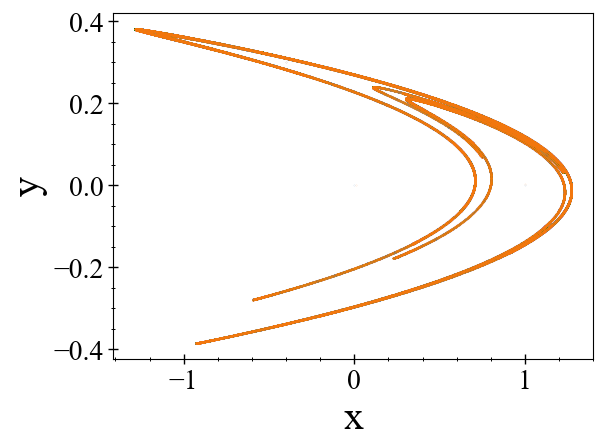

In [33]:
using PyPlot
figure(figsize=(6,4))
plot(tr[:, 1], tr[:, 2], lw = 0.0, marker = "o", ms = 0.1, alpha = 0.5);
plot(tr2[:, 1], tr2[:, 2], lw = 0.0, marker = "o", ms = 0.1, alpha = 0.5);
xlabel("x"); ylabel("y");

## Crash-course on `Dataset`

`trajectory` returns an object that is a `Dataset`:

In [34]:
tr = trajectory(henon, 100000)
println(typeof(tr))
println(summary(tr))

DynamicalSystemsBase.Dataset{2,Float64}
2-dimensional Dataset{Float64} with 100001 points


`Dataset` instances handle most data in **DynamicalSystems.jl**. `Dataset` is a wrapper of a `Vector` of `SVector`s (statically sized vectors).

In [35]:
typeof(tr.data) # this is where the `Dataset` has the data

Array{StaticArrays.SArray{Tuple{2},Float64,1,2},1}

When accessed with one index, a `Dataset` behaves as a vector of vectors

In [38]:
tr[1] # variables at first time point

2-element StaticArrays.SArray{Tuple{2},Float64,1,2}:
 0.0
 0.0

In [39]:
tr[1:5]

5-element Array{StaticArrays.SArray{Tuple{2},Float64,1,2},1}:
 [0.0, 0.0]         
 [1.0, 0.0]         
 [-0.4, 0.3]        
 [1.076, -0.12]     
 [-0.740886, 0.3228]

When accessed with two indices, a `Dataset` behaves like a matrix with each column being the timeseries of each dynamic variable

In [40]:
tr[:, 1] # timeseries of first variable

100001-element Array{Float64,1}:
  0.0     
  1.0     
 -0.4     
  1.076   
 -0.740886
  0.554322
  0.347552
  0.997188
 -0.287871
  1.18314 
 -1.0461  
 -0.177128
  0.642244
  ⋮       
  0.582553
  0.627885
  0.622831
  0.64528 
  0.603908
  0.682997
  0.528095
  0.814462
  0.229742
  1.17044 
 -0.848995
  0.342024

In [41]:
tr[1:56, 2] # time points 1:56 of second variable

56-element Array{Float64,1}:
  0.0      
  0.0      
  0.3      
 -0.12     
  0.3228   
 -0.222266 
  0.166297 
  0.104265 
  0.299156 
 -0.0863614
  0.354942 
 -0.313831 
 -0.0531385
  ⋮        
  0.128109 
  0.186576 
  0.175984 
  0.211444 
  0.144155 
  0.266456 
  0.0119177
  0.379274 
 -0.367719 
 -0.217233 
 -0.0305363
  0.230479 

In [42]:
tr[12, 1] # value of first variable at 12th timepoint

-0.17712836162447815

In [43]:
tr[1:10, 1:2] # using two ranges returns a `Dataset`

2-dimensional Dataset{Float64} with 10 points
  0.0        0.0      
  1.0        0.0      
 -0.4        0.3      
  1.076     -0.12     
 -0.740886   0.3228   
  0.554322  -0.222266 
  0.347552   0.166297 
  0.997188   0.104265 
 -0.287871   0.299156 
  1.18314   -0.0863614


# Adding a Jacobian

Let's see `henon` again:

In [44]:
henon

2-dimensional discrete dynamical system
 state:     [0.0, 0.0]
 e.o.m.:    h_eom
 in-place?  false
 jacobian:  ForwardDiff


* The last line, "`jacobian:  ForwardDiff`"
says that the Jacobian function of the equations of motion was computed automatically using the module [`ForwardDiff`](http://www.juliadiff.org/ForwardDiff.jl/stable/user/api.html). 
* The Jacobian function is a crucial component of a dynamical system, and that is why if it is not given, it is computed automatically.



Even though the automatic computation is very efficient, the best possible performance will come if you pass a "hard-coded" jacobian:

In [45]:
h_jacobian(x, p, t) = @SMatrix [-2*p[1]*x[1] 1.0; p[2] 0.0]

h_jacobian (generic function with 1 method)

* Notice that for **out-of-place** systems, the Jacobian must also have the same form as the equations of motion, namely to return an `SMatrix`.

Now, we can pass this Jacobian function to the `DiscreteDynamicalSystem` constructor as a 4th argument:

In [46]:
henon_with_jac = DiscreteDynamicalSystem(h_eom, state, p, h_jacobian)

2-dimensional discrete dynamical system
 state:     [0.0, 0.0]
 e.o.m.:    h_eom
 in-place?  false
 jacobian:  h_jacobian


To see the difference in performance, let's call this Jacobian function

In [48]:
using BenchmarkTools
a = rand(SVector{2})
@btime $(henon_with_jac.jacobian)($a, $henon.prob.p, 0);
@btime $(henon.jacobian)($a, $henon.prob.p, 0);

  2.873 ns (0 allocations: 0 bytes)
  13.548 ns (0 allocations: 0 bytes)


You can see that even though `ForwardDiff` is truly performant, the hard-coded version is much faster.

# Continuous System
* The process of creating a continuous system is identical to that of a discrete system, except that the constructor `ContinuousDynamicalSystem` is used instead. 
* In this case the function `eom` returns the time derivatives and not a "next state".


---



* We will take the opportunity to show the process of using in-place equations of motion for a continuous system, which is aimed to be used for large systems (dimensionality $\ge$ 10).

* In addition, the system we will use (Henon-Heiles) does not have any parameters.

In [49]:
# Henon-heiles famous system
# in-place form of equations of motion
# du is the derivatives vector, u is the state vector
function hheom!(du, u, p, t)
    du[1] = u[3]
    du[2] = u[4]
    du[3] = -u[1] - 2u[1]*u[2]
    du[4] = -u[2] - (u[1]^2 - u[2]^2)
    return nothing
end

# pass `nothing` as the parameters, because the system doesn't have any
hh = ContinuousDynamicalSystem(hheom!, [0, -0.25, 0.42081, 0], nothing)

4-dimensional continuous dynamical system
 state:     [0.0, -0.25, 0.42081, 0.0]
 e.o.m.:    hheom!
 in-place?  true
 jacobian:  ForwardDiff


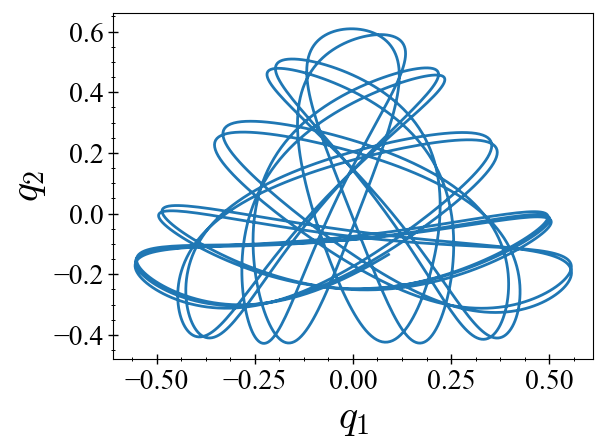

In [52]:
# Evolve the system using DifferentialEquations.jl
tr = trajectory(hh, 100.0, dt = 0.05)

figure(figsize = (6,4))
plot(tr[:, 1], tr[:, 2]);
xlabel("\$q_1\$"); ylabel("\$q_2\$");

# Handy Dandy definition table

Depending on whether your system is small or large, you want to use out-of-place or in-place equations of motion. The Jacobian function (if you wish to provide it) must also be of the same form. 

Here is a handy table that summarizes what the definitions should look like:

|          System Type         |    equations of motion    |            Jacobian            |
|:----------------------------:|:-------------------------:|:------------------------------:|
| in-place (big systems)       | `eom!(du, u, p, t)`       | `jacobian!(J, u, p, t)`        |
| out-of-place (small systems) | `eom(u, p, t) -> SVector` | `jacobian(u, p, t) -> SMatrix` |


# Time-evolution of systems & DifferentialEquations.jl
Discrete systems are evolved using internal algorithms. However, all time evolution of continuous systems is done through the [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/) library. In fact, `trajectory` for continuous systems simply wraps `solve` with some extra arguments.

Keep in mind that by default all continuous systems are evolved using the solver `Vern9()` (9th order Verner solver) with tolerances `abstol = reltol = 1e-9`. This is especially important when one wants to compare benchmarks with different packages.

It is almost certain that if you use **DynamicalSystems.jl** you want to use also DifferentialEquations.jl, due to the huge list of available features.


## When to use **DynamicalSystems.jl**?
At this point in the tutorial you might be thinking:
> How is DynamicalSystems.jl different from DifferentialEquations.jl? Seems the same to me so far...

That's because we haven't seen any special features of **DynamicalSystems.jl** yet! `trajectory` is nothing more than a "convenient shortcut".

The [contents page](https://juliadynamics.github.io/DynamicalSystems.jl/latest/#contents) of the documentation does a good job describing what is possible through **DynamicalSystems.jl**.

In addition, for usage with DifferentialEquations.jl, we can create specialized integrators that evolve the system and the tangent space, or many states of the system in parallel (at *exactly* same times):
* `tangent_integrator`
* `parallel_integrator`

These functions work for both continuous and discrete systems and also work regardless of whether the system is in-place (large), out-of-place (small) or auto-differentiated. Special attention has also been given to the performance of the integrators. 

Also, keep in mind that regardless of whether you use a `DynamicalSystem` to produce a timeseries or not, more than half of the **DynamicalSystems.jl** library is using numerical data as an input. Most of the time this numerical data is expected in the form of an `AbstractDataset` instance, which is what `trajectory` returns.

## Using DifferentialEquations.jl from a `DynamicalSystem`

It is *very* likely that other features of DifferentialEquations.jl will be useful to someone using **DynamicalSystems.jl**. However, you can still use DifferentialEquations.jl *after* you have defined a continuous dynamical system, because the field `prob` gives an `ODEProblem`:

In [ ]:
hh.prob

* **please be careful when using this problem directly, because as you can see the `tspan[end]` field is `Inf`!!!**


* One final comment: using Callbacks is *not* possible with **DynamicalSystems.jl**, because the the equations of motion function has to be assumed differentiable "everywhere".

# Docstrings

In [ ]:
?DynamicalSystem

In [ ]:
?trajectory

In [ ]:
?Dataset